In [10]:
# Library Imports
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
plt.style.use("ggplot")

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

import tensorflow as tf
keras = tf.keras

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

In [83]:
data = pd.read_csv('datasets/coins project/neo_full.csv')

In [81]:
zero_cleaner_features =['twitterFollowers','redditSubscribers','forks', 'stars',
       'subscribers', 'totalIssues', 'closedIssues','pullRequestContributors', 'additionsIn4Week', 'deletionIn4Week',
       'commitCount4Weeks']
features =['price', 'volume', 'marketCap', 'twitterFollowers',
       'redditAveragePosts48h', 'redditAverageComments48h',
       'redditSubscribers', 'redditAccountsActive48h',
        'alexaRank', 'forks', 'stars',
       'subscribers', 'totalIssues', 'closedIssues',
       'pullRequestContributors', 'additionsIn4Week', 'deletionIn4Week',
       'commitCount4Weeks']
targets = ['price_in_1_day', 'price_in_2_day',
       'price_in_3_day', 'price_in_4_day', 'price_in_5_day', 'price_in_6_day',
       'price_in_7_day', 'price_in_8_day', 'price_in_9_day', 'price_in_10_day',
       'grow_in_1_day', 'grow_in_2_day', 'grow_in_3_day', 'grow_in_4_day',
       'grow_in_5_day', 'grow_in_6_day', 'grow_in_7_day', 'grow_in_8_day',
       'grow_in_9_day', 'grow_in_10_day']

def zero_cleaner(column):
    up =0
    for i in range(len(column)):
        val = column[i]
        if column[i] == 0 and up ==0 and i >=1:
            up = column[i-1]
        if column[i] != 0 and up!=0:
            j=i
            ave = (column[i]+up)/2
            while j>=1 and column[j-1] ==0:
                column[j-1] = ave
                j-=1
            up = 0

def target_generator(data):
    b = data['price']
    for in_days in range(1,11):
        target = 'price_in_{}_day'.format(in_days)
        data[target] = data['price']
        a = data[target]
        for i in range(len(b)):
            if i<len(b)-in_days:
                a[i] = b[i+in_days]
            else:
                a[i] = b[i-5:i].mean()

def grow_label_generator(data):
    b = data['price']
    for in_days in range(1,11):
        target = 'grow_in_{}_day'.format(in_days)
        data[target] = data['price']
        a = data[target]
        for i in range(len(b)):
            if i<len(b)-in_days:
                if a[i] < b[i+in_days]:
                    a[i] = 1
                else:
                    a[i] = 0
            else:
                a[i]=-1   
                
def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def get_rmse(y_true, y_pred): 
    """
    Comp RMSE. a and b can be lists.
    Returns a scalar.
    """
    return math.sqrt(np.mean((np.array(y_true)-np.array(y_pred))**2))

def plot_trend(true_trend,pred_trend = [], split_point=0,full_x=False, title=''):
    plt.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(true_trend,'blue',label = "true values",alpha=0.6)
    if len(pred_trend) >0:
        plt.plot(pred_trend,'red',label ='prediction',alpha=0.6)
    plt.legend(loc="upper left")
    plt.title(title)
    if full_x ==True:
        plt.xticks(range(len(true_trend)))
        plt.grid(True)
    if split_point !=0:
        plt.axvline(x=split_point,linewidth=2.5)
    plt.show()

In [84]:
for feature in zero_cleaner_features:
    zero_cleaner(data[feature])
target_generator(data)                
# grow_label_generator(data)
data.head()

name                   date      price     volume   marketCap  \
0  neo  2017-09-02 00:00:00.0  30.763900   49637713  1538194980   
1  neo  2017-09-03 00:00:00.0  30.957925   21438821  1547896236   
2  neo  2017-09-04 00:00:00.0  23.023138  143111765  1151156917   
3  neo  2017-09-05 00:00:00.0  23.674946   53125834  1183747315   
4  neo  2017-09-06 00:00:00.0  21.515456   46065917  1075772788   

   twitterFollowers  redditAveragePosts48h  redditAverageComments48h  \
0             65687                      3                       136   
1             66436                      3                       123   
2             67419                      3                       127   
3             68640                      3                       171   
4             70173                      2                       165   

   redditSubscribers  redditAccountsActive48h  telegramChanelUserCount  \
0              22013                      703                        0   
1              22277                      580                        0   
2              22821                      963                        0   
3              23713                     1309                        0   
4              24351                     1097                        0   

   alexaRank  bingMatches  forks  stars  subscribers  totalIssues  \
0      39974            0    279    799          208           39   
1      39580            0    281    805          209           39   
2      39065            0    281    809          209           39   
3      38513            0    282    812          209           39   
4      37837            0    284    816          210           40   

   closedIssues  pullRequestsMerged  pullRequestContributors  \
0            32                   0                       10   
1            32                   0                       10   
2            32                   0                       10   
3            32                   0                       10   
4            33                   0                       10   

   additionsIn4Week  deletionIn4Week  commitCount4Weeks  price_in_1_day  \
0                 0                0                 19       30.957925   
1                 0                0                 19       23.023138   
2                 0                0                 19       23.674946   
3                 0                0                 20       21.515456   
4                 0                0                 20       30.842616   

   price_in_2_day  price_in_3_day  price_in_4_day  price_in_5_day  \
0       23.023138       23.674946       21.515456       30.842616   
1       23.674946       21.515456       30.842616       25.753812   
2       21.515456       30.842616       25.753812       22.050382   
3       30.842616       25.753812       22.050382       23.210249   
4       25.753812       22.050382       23.210249       21.672536   

   price_in_6_day  price_in_7_day  price_in_8_day  price_in_9_day  \
0       25.753812       22.050382       23.210249       21.672536   
1       22.050382       23.210249       21.672536       20.868057   
2       23.210249       21.672536       20.868057       20.143343   
3       21.672536       20.868057       20.143343       15.095051   
4       20.868057       20.143343       15.095051       18.174860   

   price_in_10_day  
0        20.868057  
1        20.143343  
2        15.095051  
3        18.174860  
4        20.133571

In [85]:
cols = ['price', 'volume', 'marketCap', 'twitterFollowers',
       'redditAveragePosts48h', 'redditAverageComments48h',
       'redditSubscribers', 'redditAccountsActive48h',
       'telegramChanelUserCount', 'alexaRank', 'bingMatches', 'forks', 'stars',
       'subscribers', 'totalIssues', 'closedIssues', 'pullRequestsMerged',
       'pullRequestContributors', 'additionsIn4Week', 'deletionIn4Week',
       'commitCount4Weeks']
for i , row in data.iterrows():
    for col in cols:
        for hor in range(1,50):
            try:
                data.at[i, 'diff_{}_in_{}_day'.format(col, hor)] = data.at[i, col] - data.at[i-hor, col]
            except:
                pass
    

In [73]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(data.tail(data.shape[0]-11).corr()['price_in_1_day'])

price                                      0.992852
volume                                    -0.171651
marketCap                                  0.991750
twitterFollowers                          -0.311579
redditAveragePosts48h                      0.616053
redditAverageComments48h                   0.690529
redditSubscribers                         -0.386390
redditAccountsActive48h                    0.633658
telegramChanelUserCount                         NaN
alexaRank                                 -0.694645
bingMatches                                     NaN
forks                                     -0.590178
stars                                     -0.552349
subscribers                               -0.160570
totalIssues                               -0.595544
closedIssues                              -0.563037
pullRequestsMerged                              NaN
pullRequestContributors                   -0.552594
additionsIn4Week                          -0.186789
deletionIn4W

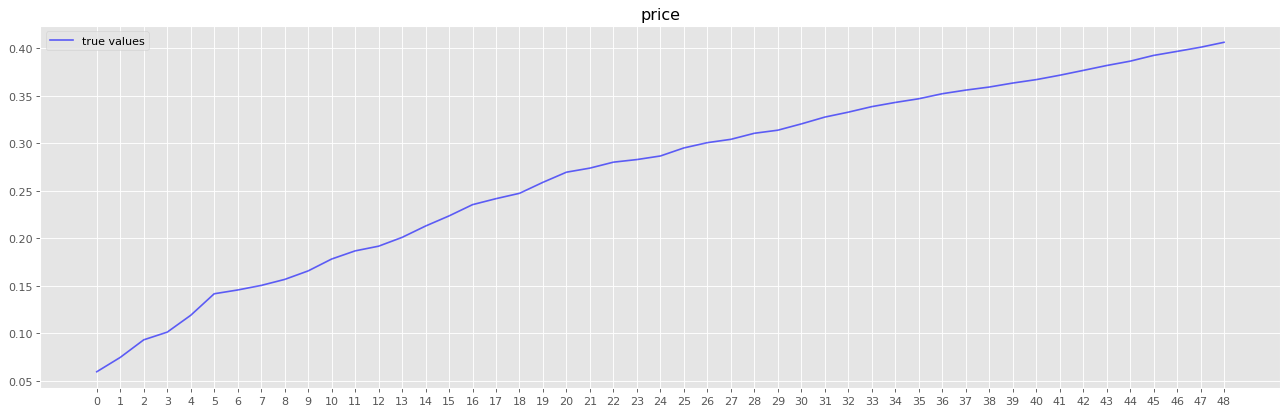

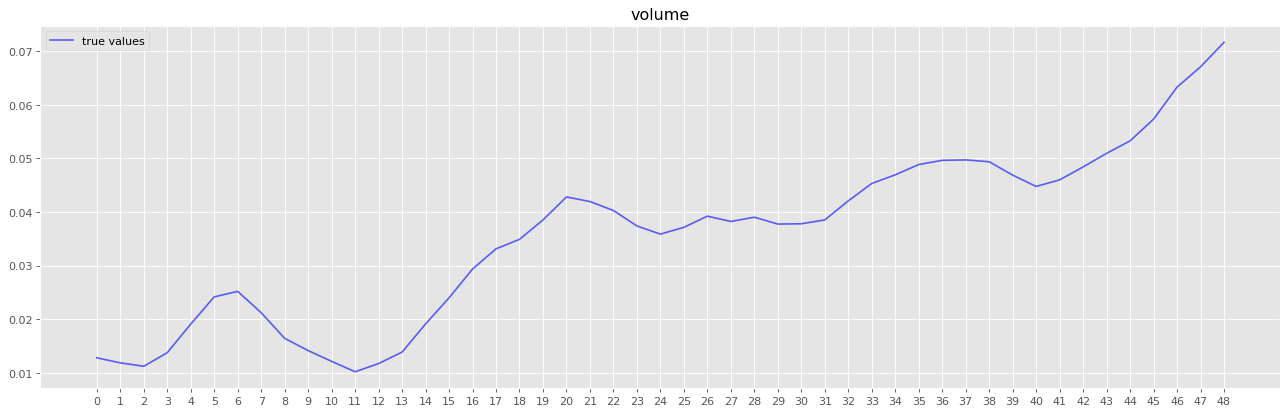

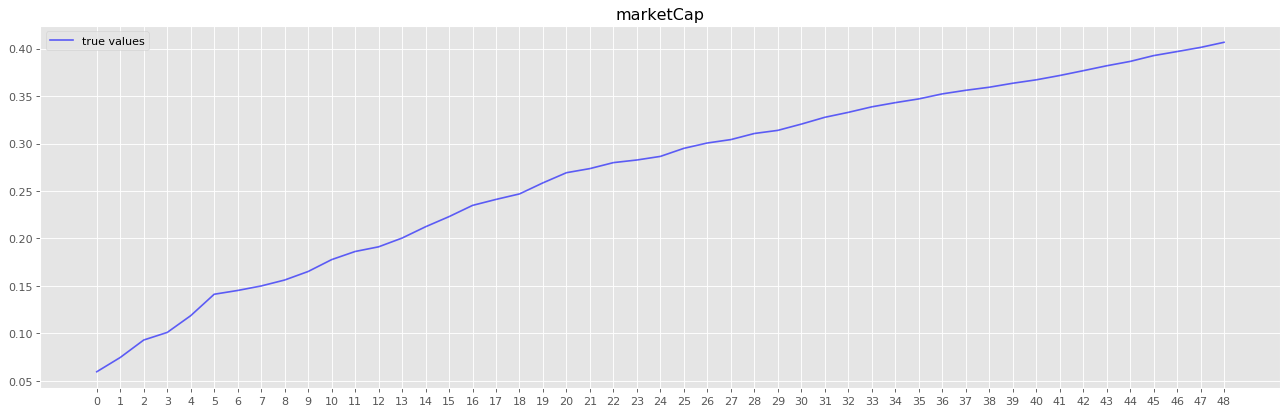

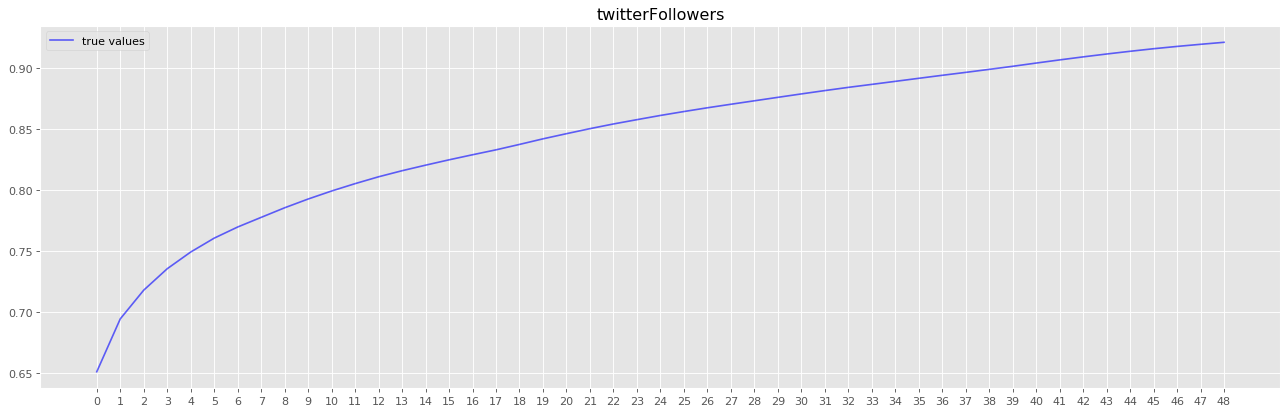

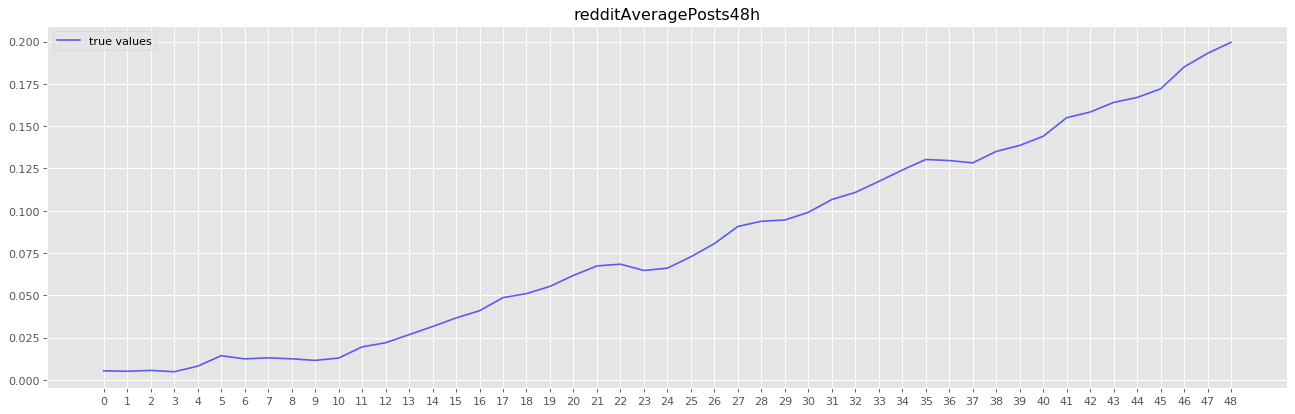

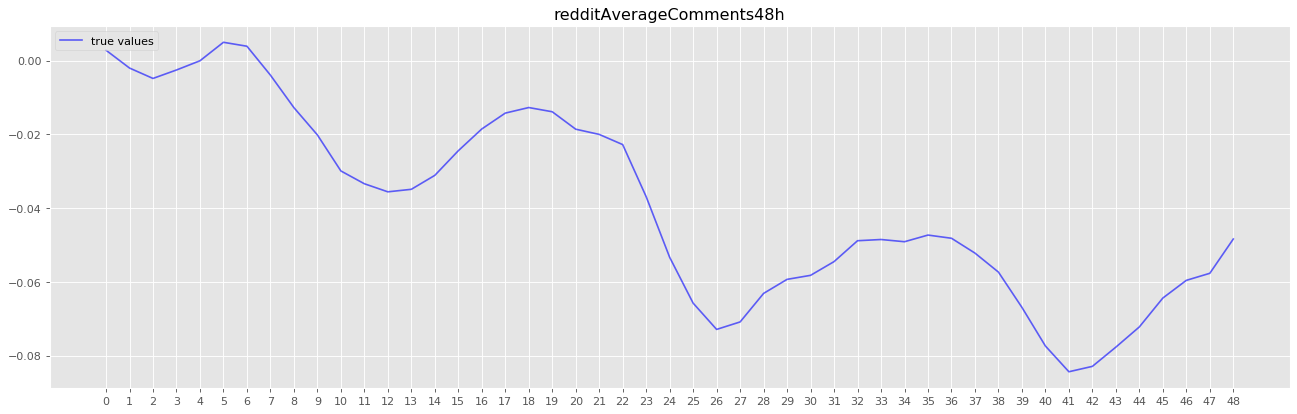

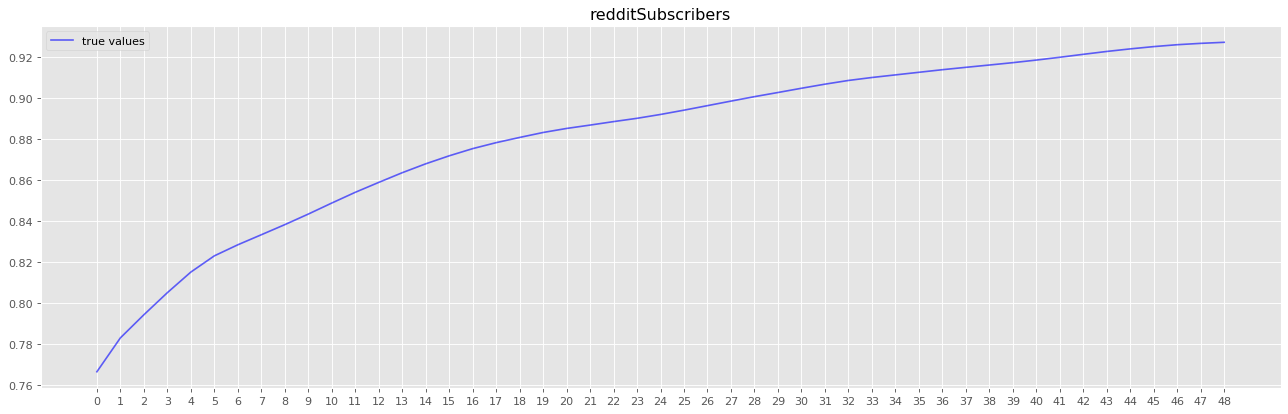

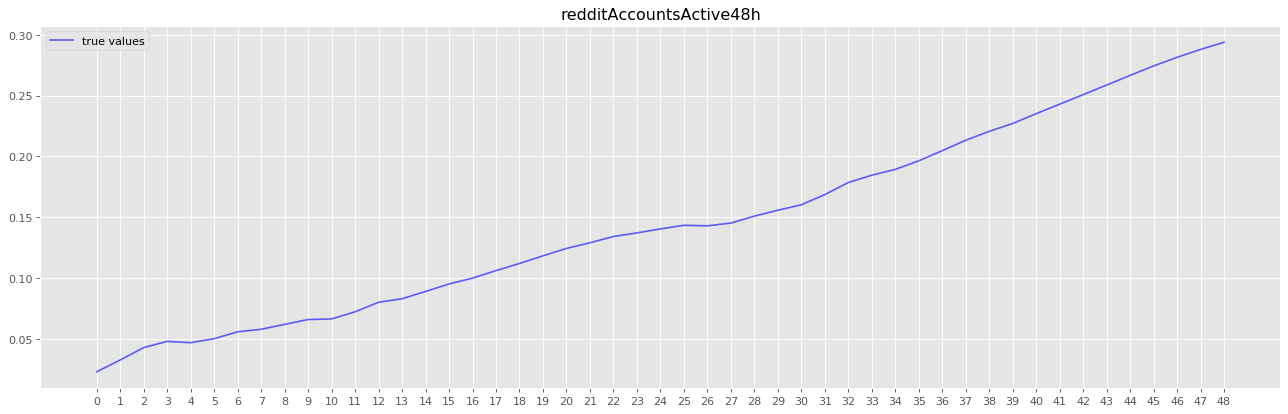

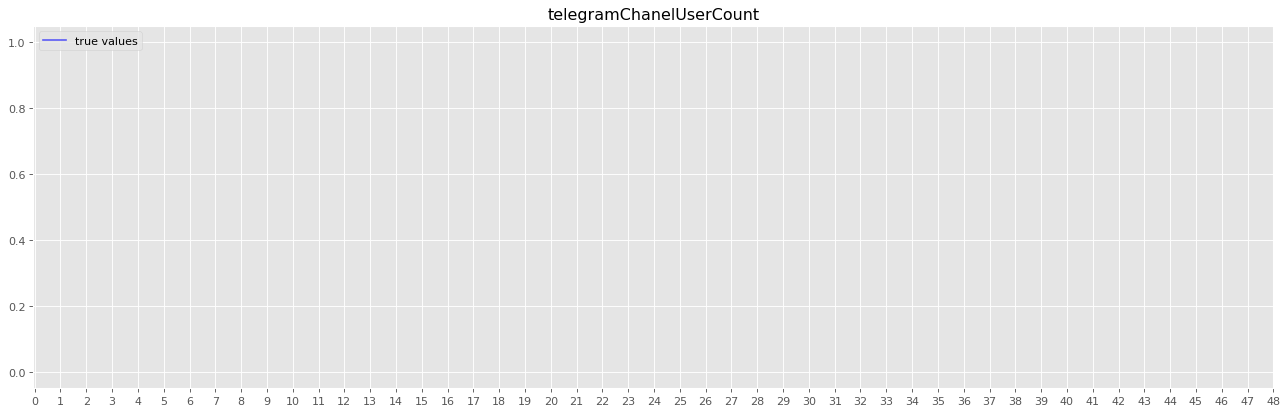

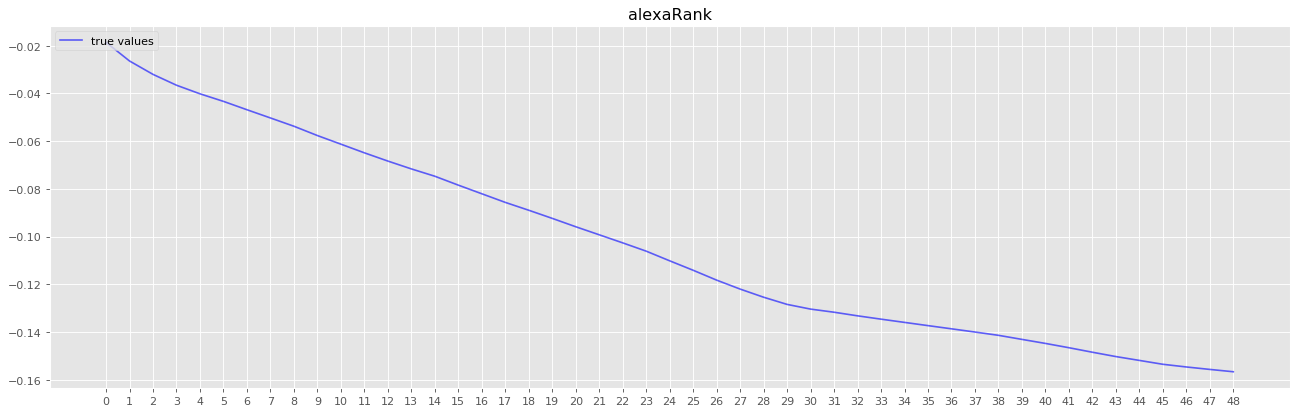

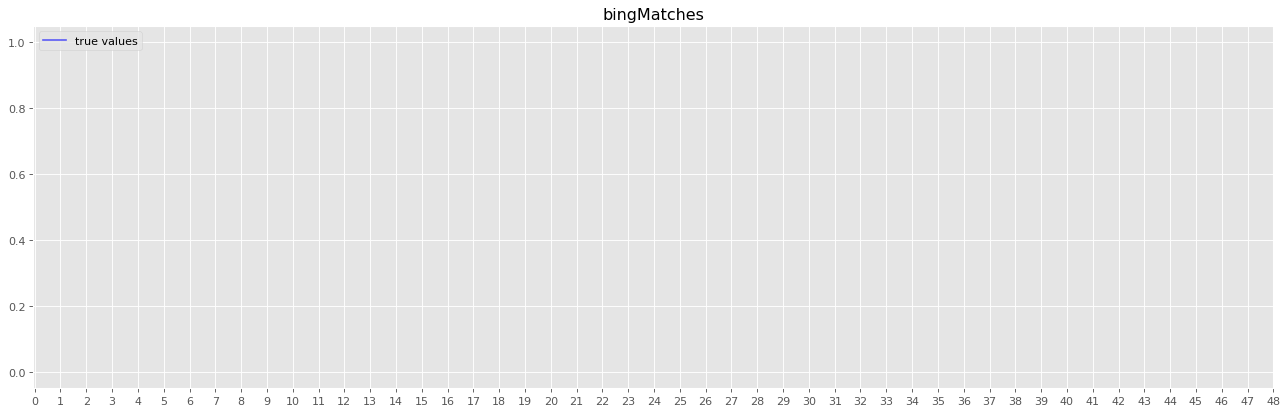

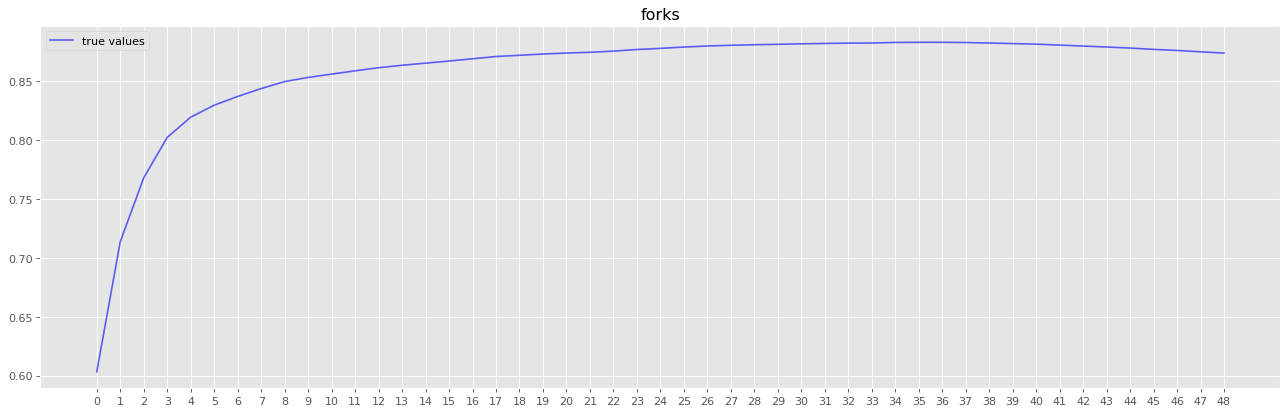

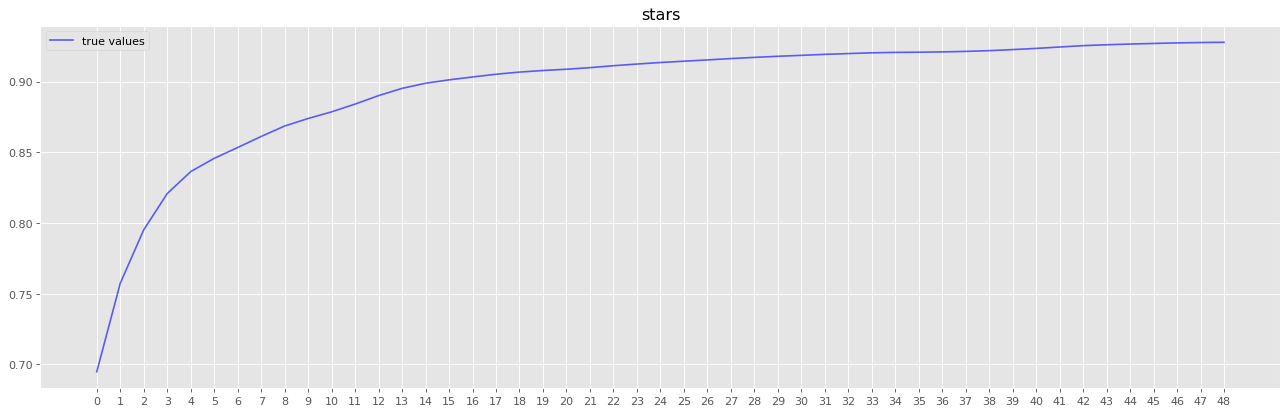

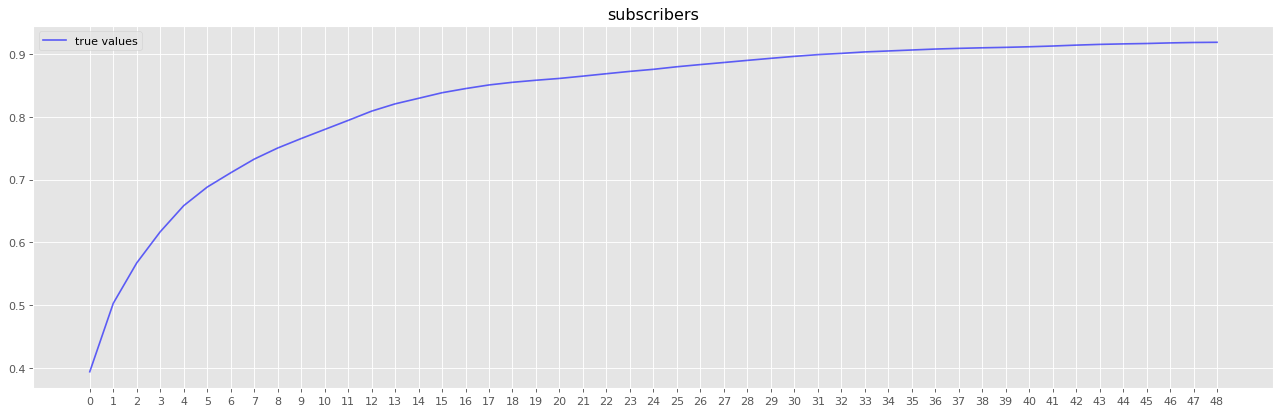

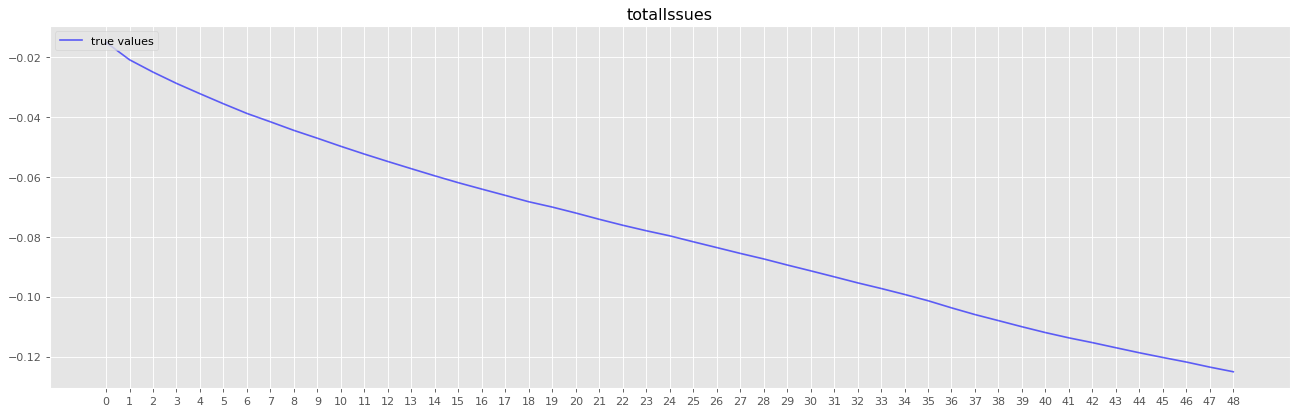

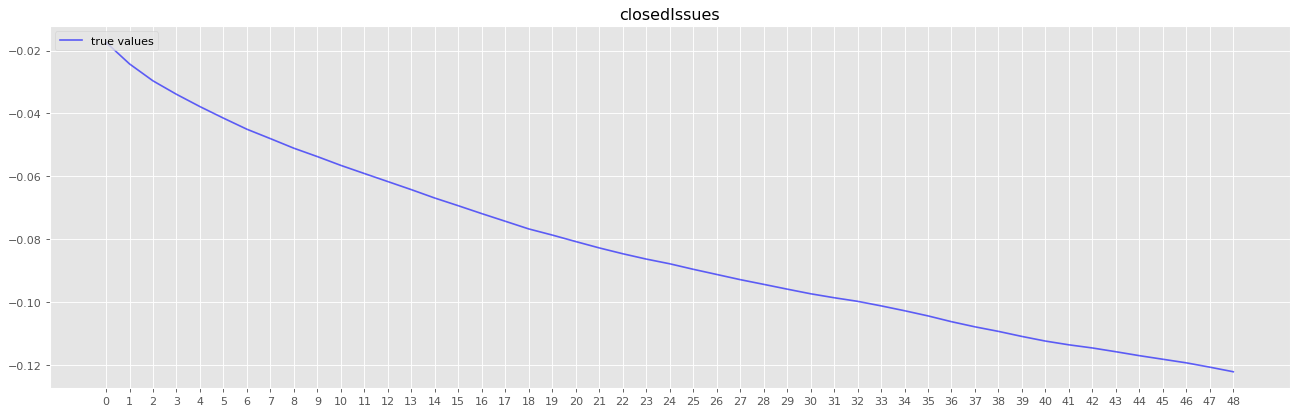

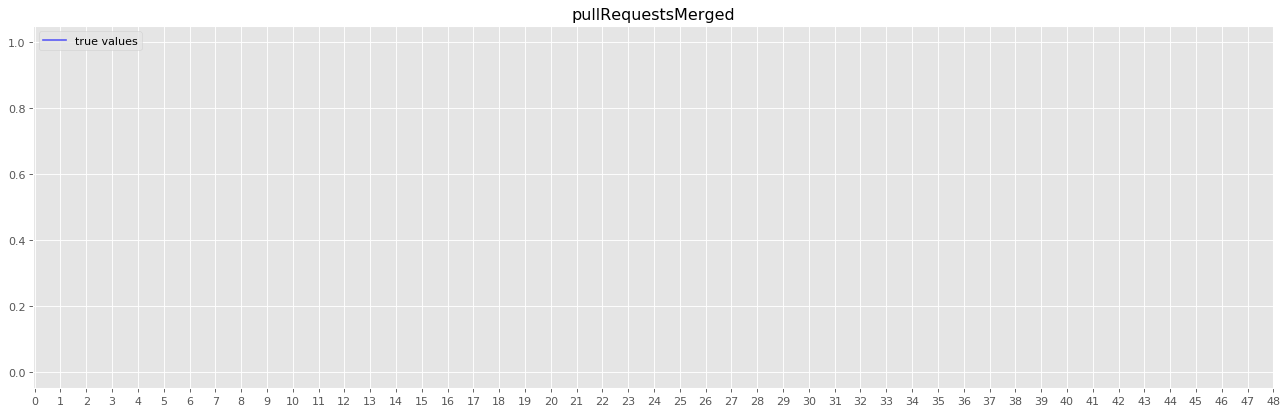

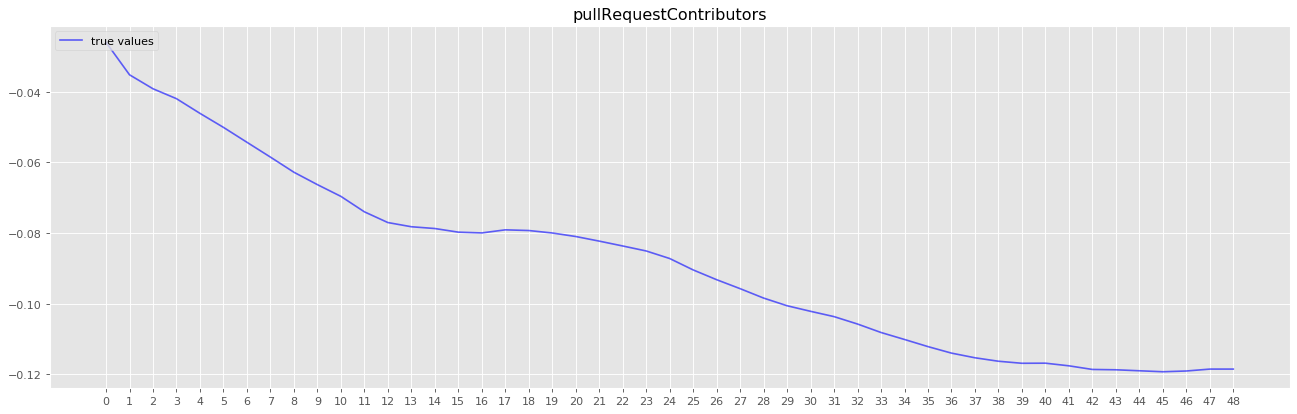

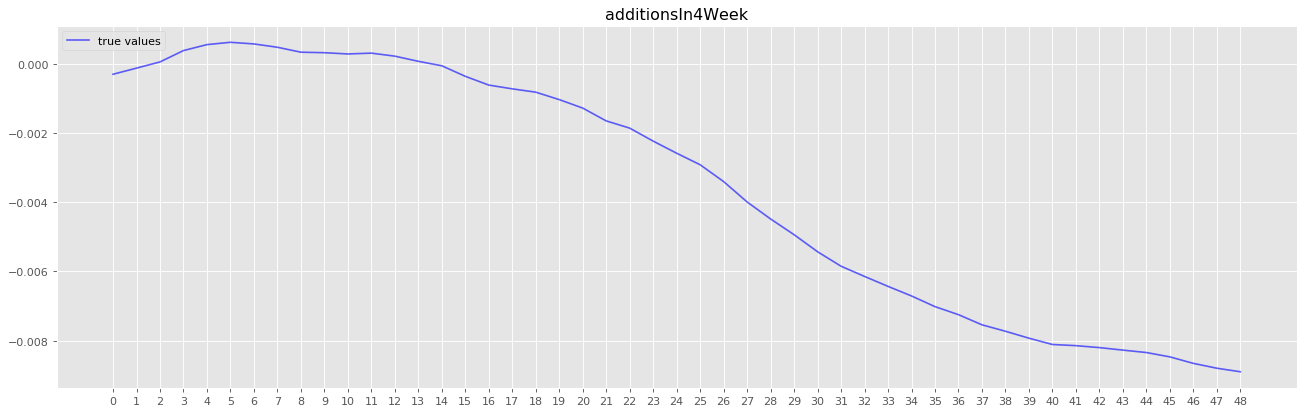

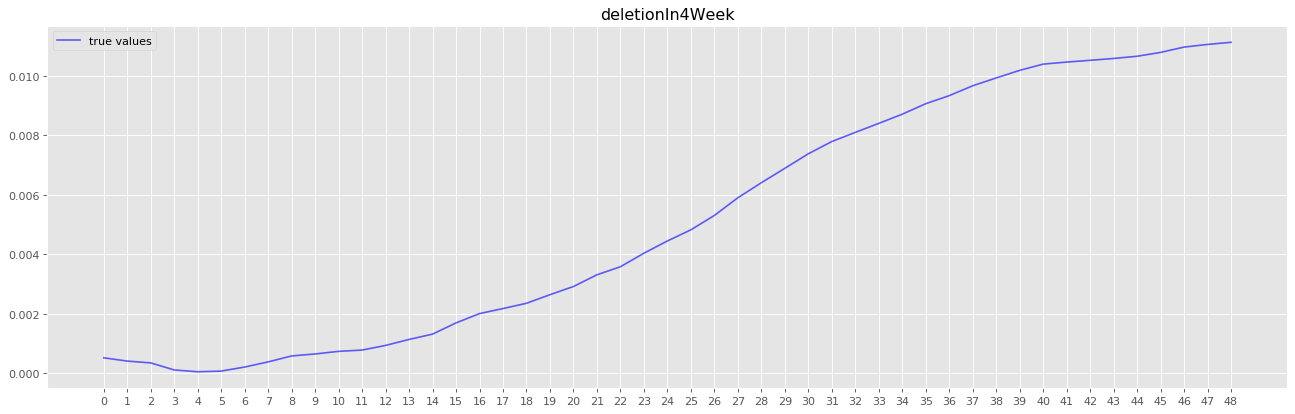

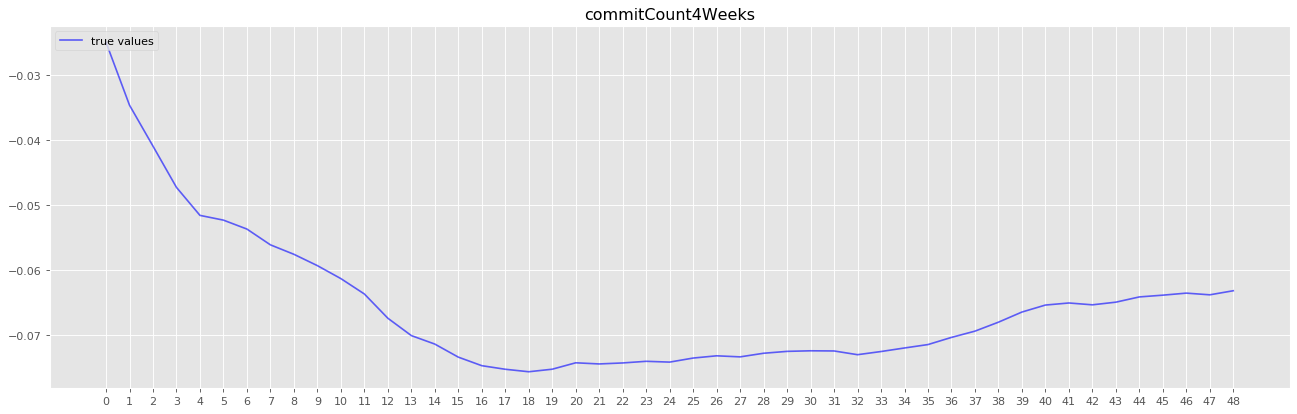

In [87]:
cor = data.tail(data.shape[0]-50).corr()['price_in_1_day']
for col in cols:
    a = []
    for hor in range(1,50):
        a.append(cor['diff_{}_in_{}_day'.format(col, hor)])   
    plot_trend(a,title = col, full_x=True)

In [89]:
temp = data.tail(data.shape[0]-50)

In [113]:
type(temp.columns.values.tolist())
c = temp.columns.values.tolist()
cc =['name' , 'date','price_in_1_day','price_in_2_day','price_in_3_day','price_in_4_day','price_in_5_day','price_in_6_day','price_in_7_day','price_in_8_day','price_in_9_day','price_in_10_day']


In [114]:
col = [x for x in c if x not in cc]

In [116]:
temp = temp[col]

In [117]:
temp

price     volume   marketCap  twitterFollowers  \
50    27.173318   21332463  1358665924            106235   
51    28.884318   23605333  1444215881            106582   
52    27.715766   16326415  1385788304            107097   
53    30.200155   52466292  1510007728            107834   
54    28.388078   18851985  1419403921            108898   
...         ...        ...         ...               ...   
1052  10.641138  147802809   750519473            319958   
1053  10.401539  139362127   734073815            319907   
1054  11.172521  247577766   787658281            319940   
1055  11.573522  222309605   818798717            320004   
1056  11.427525  225882227   805812992            319983   

      redditAveragePosts48h  redditAverageComments48h  redditSubscribers  \
50                        1                        22              32486   
51                        1                        36              32621   
52                        1                        44              32757   
53                        1                        37              32899   
54                        1                        43              33027   
...                     ...                       ...                ...   
1052                      0                         7              99806   
1053                      0                         9              99820   
1054                      1                        10              99832   
1055                      1                         7              99836   
1056                      1                         9              99846   

      redditAccountsActive48h  telegramChanelUserCount  alexaRank  \
50                        872                        0      28129   
51                        556                        0      28129   
52                        534                        0      27991   
53                        606                        0      27957   
54                        671                        0      28013   
...                       ...                      ...        ...   
1052                     1510                        0     192818   
1053                     1635                        0     192818   
1054                     2135                        0     192818   
1055                     1989                        0     192818   
1056                     1755                        0     192818   

      bingMatches  forks  stars  subscribers  totalIssues  closedIssues  \
50              0    339    965          239           49            43   
51              0    340    966          240           49            43   
52              0    343    970          239           51            44   
53              0    343    971          240           51            44   
54              0    348    975          242           52            45   
...           ...    ...    ...          ...          ...           ...   
1052            0    906   2991          368          758           636   
1053            0    905   2992          368          760           636   
1054            0    905   2993          368          760           636   
1055            0    906   2995          369          761           636   
1056            0    906   2997          369          762           636   

      pullRequestsMerged  pullRequestContributors  additionsIn4Week  \
50                     0                       13                 0   
51                     0                       13                 0   
52                     0                       13                 0   
53                     0                       14                 0   
54                     0                       14                 0   
...                  ...                      ...               ...   
1052                   0                       51              1692   
1053                   0                       51              1692   
1054   

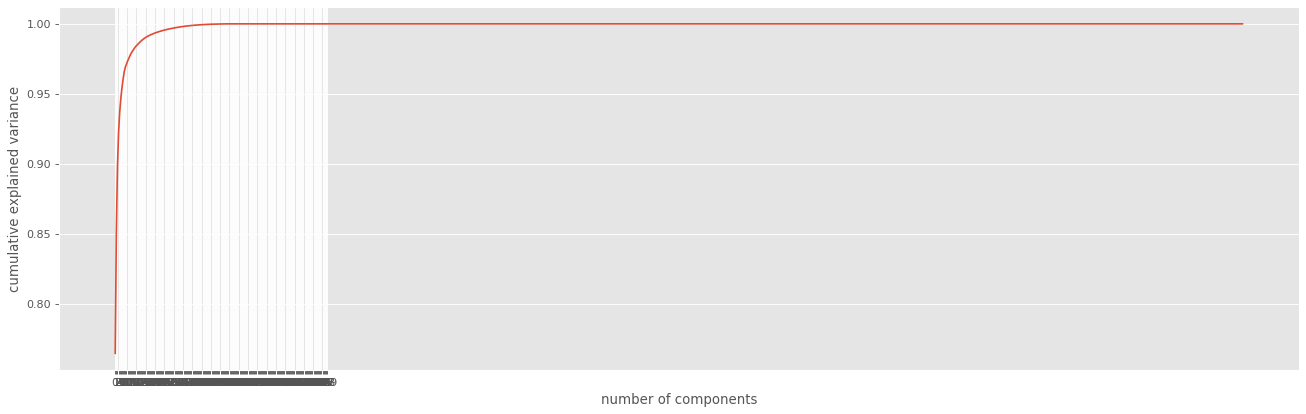

In [118]:
from sklearn.decomposition import PCA
pca = PCA().fit(temp)


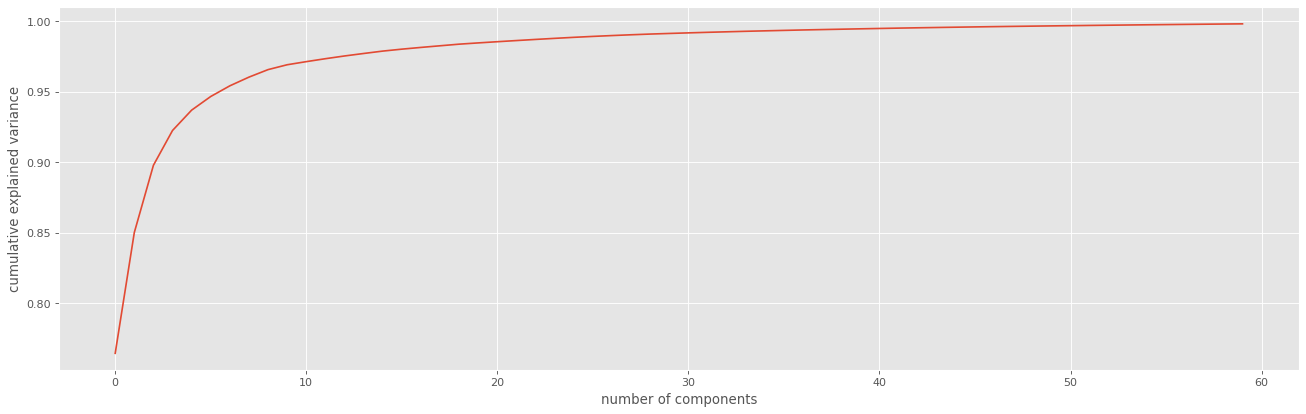

In [124]:
plt.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(np.cumsum(pca.explained_variance_ratio_)[:60])
plt.xlabel('number of components')
plt.grid(True)
# plt.xticks(range(190))
plt.ylabel('cumulative explained variance');

In [125]:
np.cumsum(pca.explained_variance_ratio_)[:60]

array([0.76445624, 0.85009023, 0.89771954, 0.92237649, 0.93680299,
       0.94646944, 0.95402857, 0.96019355, 0.96551367, 0.96895835,
       0.97116479, 0.97324617, 0.97518278, 0.97694124, 0.97863696,
       0.98001497, 0.98124511, 0.98240283, 0.98355215, 0.98444299,
       0.98529031, 0.98610687, 0.98690709, 0.98766899, 0.98839239,
       0.98904956, 0.98964818, 0.99020606, 0.99071027, 0.99114348,
       0.9915519 , 0.99194644, 0.99231054, 0.99267179, 0.9929934 ,
       0.99330938, 0.99361832, 0.99389262, 0.99415687, 0.99442035,
       0.99467725, 0.99492565, 0.99515423, 0.99536865, 0.99557706,
       0.99577858, 0.99597608, 0.99615609, 0.99632981, 0.99650023,
       0.99666191, 0.99682265, 0.99697925, 0.99713453, 0.99728151,
       0.99742627, 0.99756119, 0.9976951 , 0.99782562, 0.99794837])

In [126]:
pca_data = pd.DataFrame(PCA(n_components=60).fit_transform(temp))

In [127]:
pca_data

0             1             2             3             4   \
0     8.912913e+08  7.711548e+08 -8.694576e+08 -9.311215e+08  3.564882e+07   
1     1.468169e+09  7.604893e+08 -8.037688e+08 -5.901754e+08  3.792729e+07   
2     1.043755e+09  9.524142e+08 -8.669809e+08 -5.337925e+08  5.702013e+07   
3     1.799895e+09  7.592887e+08 -7.525102e+08 -1.927985e+08  3.014211e+08   
4     1.144416e+09  9.960879e+08 -8.311720e+08 -1.829806e+08  1.305912e+08   
...            ...           ...           ...           ...           ...   
1002 -1.825959e+08 -4.187029e+08 -9.055761e+08 -4.636953e+07 -1.235017e+09   
1003 -2.828723e+08 -3.889063e+08 -9.281531e+08 -1.036014e+08 -1.224160e+09   
1004  1.226210e+08 -5.394061e+08 -8.967959e+08  1.114727e+07 -4.629362e+08   
1005  3.388615e+08 -5.711752e+08 -8.740674e+08  4.308394e+07 -5.661527e+08   
1006  2.848269e+08 -5.256611e+08 -8.971187e+08  2.776553e+07 -4.951588e+08   

                5             6             7             8             9   \
0    -6.322593e+08 -2.828863e+08 -5.688601e+08  2.312126e+08  1.816774e+08   
1    -6.868043e+08 -2.059584e+08 -7.312256e+08  1.271664e+08  8.951177e+07   
2    -6.210797e+08 -2.083761e+08 -7.862439e+08 -1.021556e+08  1.168236e+07   
3    -6.408366e+08 -1.266639e+08 -8.534144e+08 -2.322965e+08 -1.278508e+08   
4    -5.717793e+08 -9.938170e+07 -7.873704e+08 -4.655067e+08 -1.205079e+08   
...            ...           ...           ...           ...           ...   
1002 -2.828137e+08  9.281140e+07 -1.119789e+08 -1.695525e+08  7.182883e+06   
1003 -3.000566e+08  8.340580e+07 -8.661681e+07 -1.866949e+08 -2.069950e+07   
1004 -1.659928e+08  1.058878e+08 -2.629598e+07 -7.796138e+07 -3.339862e+07   
1005 -2.450914e+08  1.027658e+08 -2.261343e+07 -6.765173e+07 -4.559837e+07   
1006 -2.242861e+08  7.347545e+07  1.649491e+07 -5.349968e+07 -4.584431e+06   

                10            11            12            13            14  \
0    -7.735087e+07 -3.829074e+08  1.140094e+08 -9.067116e+07  1.606540e+08   
1    -3.338854e+08 -1.116259e+08 -9.532062e+07 -7.165178e+07  2.909808e+08   
2    -7.496056e+07  2.296279e+08 -2.010714e+08 -4.285393e+07  2.600536e+08   
3     2.811071e+08  1.792378e+08 -8.051851e+07  6.573289e+07  3.142552e+07   
4     3.984279e+08 -1.822812e+08 -7.269652e+07  9.456177e+07 -2.473827e+08   
...            ...           ...           ...           ...           ...   
1002  4.304335e+07 -6.364905e+07  2.037209e+07  3.768497e+08  2.183728e+08   
1003  8.107310e+07 -5.303719e+07  7.497878e+05  3.707482e+08  1.858228e+08   
1004  7.604624e+07 -5.737372e+07  4.262861e+07  4.829101e+08  2.417110e+08   
1005  7.251701e+07 -6.429509e+07  5.030591e+07  4.232412e+08  1.960164e+08   
1006  6.724234e+07 -6.323068e+07  4.391152e+07  4.006142e+08  2.140414e+08   

                15            16            17            18            19  \
0    -6.333985e+07  1.527833e+08  6.946700e+07  7.234801e+07  1.587423e+07   
1    -1.968386e+08 -3.900112e+07  1.241212e+07  7.551965e+07 -2.938673e+07   
2    -1.718557e+08 -1.489945e+08 -8.270498e+07  3.491362e+07  9.579963e+06   
3    -1.754394e+08 -7.540844e+07 -1.413498e+08 -2.015927e+07 -8.102740e+07   
4    -2.780896e+07  2.712658e+07 -7.141300e+07 -1.004610e+08  5.645008e+07   
...            ...           ...           ...           ...           ...   
1002 -2.579505e+07 -2.503818e+06  8.460618e+07 -1.035759e+07 -5.195837e+07   
1003  1.254783e+07  1.313520e+07  6.601771e+07  4.399242e+07 -1.850569e+07   
1004 -1.295931e+07  4.678598e+07  2.335247e+07  6.995388e+07 -2.596179e+07   
1005 -1.136631e+07  7.260521e+07 -1.493517e+07  4.739180e+07  7.465429e+06   
1006 -1.228268e+07  5.972436e+07 -1.452008e+07 -4.601474e+06  4.054828e+07   

                20            21            22            23            24  \
0    -6.225833e+07 -1.037586e+08 -5.365877e+07 -3.746383e+07 -8.693213e+07   
1    -9.305658e+07  2.302155e+07 -3.676789e+07  1.918291e+08 -8.577914e+07   
2    -1.102754e+08 -5.997876e+07  

In [136]:
data.tail(data.shape[0]-50)['price_in_1_day'].values

array([28.88431762, 27.71576609, 30.20015456, ..., 11.57352175,
       11.4275254 , 10.86639386])

In [143]:
pca_data['target'] = data.tail(data.shape[0]-50)['price_in_1_day'].values - data.tail(data.shape[0]-50)['price'].values 

In [150]:
pca_data['price'] = data.tail(data.shape[0]-50)['price'].values
pca_data['price_in_1_day'] = data.tail(data.shape[0]-50)['price_in_1_day'].values

In [142]:
data.tail(data.shape[0]-50)['price_in_1_day'].values - data.tail(data.shape[0]-50)['price'].values 

array([ 1.71099913, -1.16855153,  2.48438847, ...,  0.40100069,
       -0.14599635, -0.56113154])

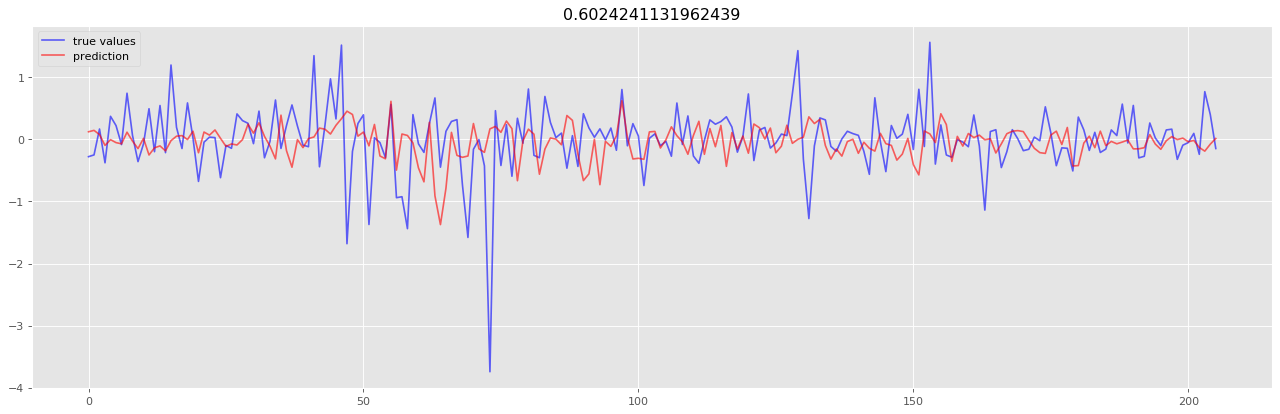

In [183]:
from scipy.stats.stats import pearsonr 
def make_report(y_pred , y_true):
    print ("")
    print ("Classification Report: ")
    print (classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    print(cm)
    
import xgboost as xgb
i = 800
train = pca_data[:i]
test = pca_data[i:pca_data.shape[0]-1]
X_train =train.drop(['target', 'price_in_1_day', 'price'], axis = 1)
y_train =train['target']
X_test =test.drop(['target', 'price_in_1_day', 'price'], axis = 1)
y_test =test['target']
#     ss = StandardScaler()
#     ss.fit(X_train)
#     X_train = pd.DataFrame(ss.transform(X_train))
#     X_test = pd.DataFrame(ss.transform(X_test))
    
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
    
    # set xgboost params
param = {
        'max_depth': 20,  
        'eta': 0.1,  
        'objective': 'reg:squarederror',  
            } 
num_round = 50  

bst = xgb.train(param, dtrain, num_round)


y_pred = bst.predict(dtest)
    
plot_trend(y_test.values,y_pred, title= get_rmse(y_test.values, y_pred))


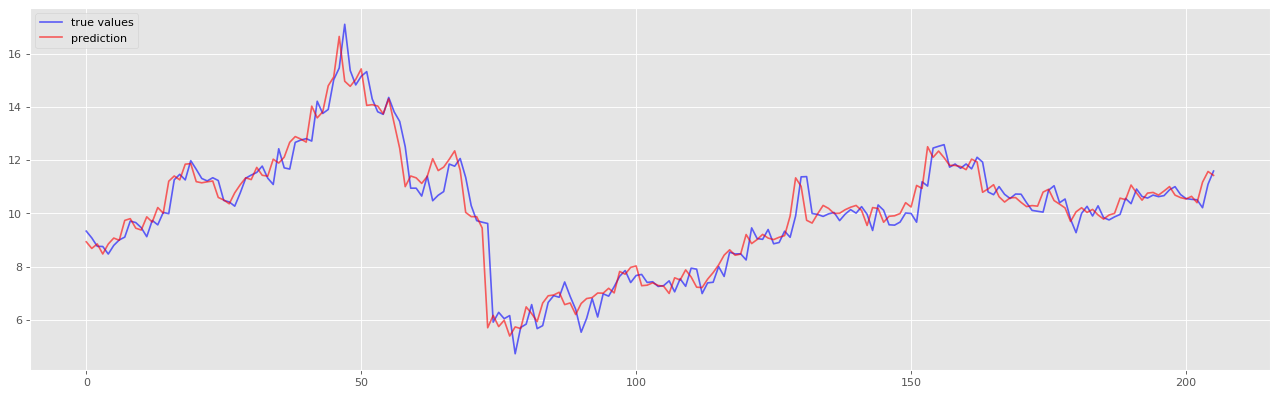

4.151471310955394 0.6024241131962439 (0.962037213716757, 5.174805801405767e-117)
3.490220786727548 0.5377421759437968 (0.9689357404140866, 9.602858983217453e-126)


In [184]:
plot_trend(y_pred + test['price'].values, test['price_in_1_day'].values)
print(get_mape(y_pred + test['price'].values, test['price_in_1_day'].values),get_rmse(y_pred + test['price'].values, test['price_in_1_day'].values),pearsonr(y_pred + test['price'].values, test['price_in_1_day'].values) )
print(get_mape(test['price'].values, test['price_in_1_day'].values),get_rmse(test['price'].values, test['price_in_1_day'].values),pearsonr(test['price'].values, test['price_in_1_day'].values) )